### This is a self-driving car project to detect vehicle on the road!

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *

In [2]:
cars_far = glob.glob('./vehicles/GTI_Far/*.png')
cars_middle = glob.glob('./vehicles/GTI_MiddleClose/*.png')
cars_left = glob.glob('./vehicles/GTI_Left/*.png')
cars_right = glob.glob('./vehicles/GTI_Right/*.png')
cars_extracted = glob.glob('./vehicles/KITTI_extracted/*.png')

In [3]:
notcars = glob.glob('./non-vehicles/Extras/*.png')
notcars += glob.glob('./non-vehicles/GTI/*.png')

In [5]:
cars=cars_far+cars_middle+cars_left+cars_right+cars_extracted

In [6]:
len(cars)

8792

In [7]:
len(notcars)

8968

### Firstly, we need to store all the image data into .p file so that we can get data more easily

I am planning to set 80% as the training data and 20% as the data set 

In [8]:
pickle_file = 'data.p'
print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'cars': cars,
                'notcars': notcars
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Saving data to pickle file...


In [9]:
datafile = 'data.p'
with open(datafile, mode='rb') as f:
    data = pickle.load(f)

Over here, split data into training test set and test data set

In [10]:
cars_data=data['cars']
notcars_data=data['notcars']
cars_train,cars_test=train_test_split(cars_data,test_size=0.2)
notcars_train,notcars_test=train_test_split(notcars_data,test_size=0.2)

We need to create a function used to get features from images

In [106]:
def single_img_features(img, color_space='YCrCb', spatial_size=(16, 16),
                        hist_bins=24, orient=5, 
                        pix_per_cell=8, cell_per_block=5, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

### Let's see a simple demo how to get Histogram of Oriented Gradients

In [107]:
%matplotlib inline
pix_per_cell=8
cell_per_block=2
orient=9
img=cars_train[0]
img=mpimg.imread(img)
demo_features=[]
hog_image_demo=[]
for channel in range(img.shape[2]):
    features,hog_image=get_hog_features(img[:,:,channel], orient, pix_per_cell,\
                                        cell_per_block, vis=True, feature_vec=True)
    demo_features.append(features)
    hog_image_demo.append(hog_image)

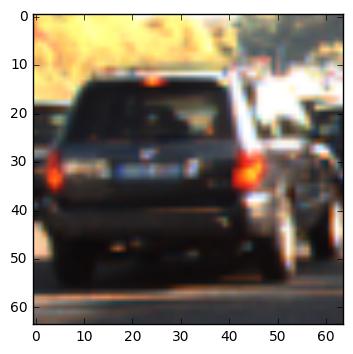

In [108]:
plt.imshow(img)

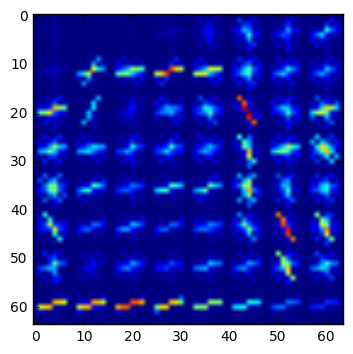

In [109]:
plt.imshow(hog_image_demo[0])

In [119]:
demo_features[0].shape

(1764,)

In [138]:
feature_training_cars=[]
for file in cars_train:
    img=mpimg.imread(file)
    draw_img = img.astype(np.float32)/255
    img_features = single_img_features(draw_img, color_space='YCrCb', spatial_size=(32,32),\
                                       hist_bins=32, orient=9,\
                                       pix_per_cell=8, cell_per_block=2, hog_channel='ALL',\
                                       spatial_feat=True, hist_feat=True, hog_feat=True)
    feature_training_cars.append(img_features)

feature_testing_cars=[]
for file in cars_test:
    img=mpimg.imread(file)
    draw_img = img.astype(np.float32)/255
    img_features = single_img_features(draw_img, color_space='YCrCb', spatial_size=(32,32),\
                                       hist_bins=32, orient=9,\
                                       pix_per_cell=8, cell_per_block=2, hog_channel='ALL',\
                                       spatial_feat=True, hist_feat=True, hog_feat=True)
    feature_testing_cars.append(img_features)

feature_training_notcars=[]
for file in notcars_train:
    img=mpimg.imread(file)
    draw_img = img.astype(np.float32)/255
    img_features = single_img_features(draw_img, color_space='YCrCb', spatial_size=(32,32),\
                                       hist_bins=32, orient=9,\
                                       pix_per_cell=8, cell_per_block=2, hog_channel='ALL',\
                                       spatial_feat=True, hist_feat=True, hog_feat=True)
    feature_training_notcars.append(img_features)

feature_testing_notcars=[]
for file in notcars_test:
    img=mpimg.imread(file)
    draw_img = img.astype(np.float32)/255
    img_features = single_img_features(draw_img, color_space='YCrCb', spatial_size=(32,32),\
                                       hist_bins=32, orient=9,\
                                       pix_per_cell=8, cell_per_block=2, hog_channel='ALL',\
                                       spatial_feat=True, hist_feat=True, hog_feat=True)
    feature_testing_notcars.append(img_features)


In [158]:
ystart = 400
ystop = 656
scale = 1.5

In [159]:
#didn't use this functions in this project, but it is useful to improve efficiency of the algorithms
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    boxlist=[]
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxlist.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img,boxlist
    

### Now features have been extracted, now we need to use SVM to explore data

In [141]:
# Create an array stack of feature vectors
X = np.vstack((feature_training_cars,feature_training_notcars)).astype(np.float64)  
y_train = np.hstack((np.ones(len(feature_training_cars)), np.zeros(len(feature_training_notcars))))
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
X_train=scaled_X

In [142]:
X_train[0].shape

(8460,)

In [143]:
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print("the time for fitting:{}".format(t2-t))

the time for fitting:17.892841577529907


In [144]:
X_test = np.vstack((feature_testing_cars,feature_testing_notcars)).astype(np.float64)  
y_testing = np.hstack((np.ones(len(feature_testing_cars)), np.zeros(len(feature_testing_notcars))))
X_test_scaler = StandardScaler().fit(X_test)
X_testing = X_test_scaler.transform(X_test)

In [145]:
X_testing[0].shape

(8460,)

Now we can use our classifier to test accuracy on our test data set

In [146]:
print('Test Accuracy of SVC = ', round(svc.score(X_testing, y_testing), 4))

Test Accuracy of SVC =  0.9927


## Then, we need to construct a function to search windows

In [147]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(16, 16), hist_bins=24, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [148]:
# Define a function to return HOG features and visualization
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [149]:
color_space = 'YCrCb'
spatial_size = (32,32)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

As for the sliding window function, I set the window-size as 64, and the overlap ratio as 0.7, the reason is that using 0.7 as overlap can help me to find cars quickly(compared to lower ratio). Also, it is an appropriate size and overlap ratio to find the specific cars

In [153]:
#Got an idea from the forum and referenced some codes from there
def get_rectangle_cars(image):
    hot_windows = []
    all_windows = []
    
    X_start_stop =[[600,1200],[None,None],[None,None],[None,None]]
    XY_window = [[64,64]]
    XY_overlap = [(0.7,0.7)]                 
    Y_start_stop =[[400,655]]    
    
    
    
    for i in range(len(Y_start_stop)):
        windows = slide_window(image, x_start_stop=X_start_stop[i], y_start_stop=Y_start_stop[i], 
                            xy_window=XY_window[i], xy_overlap=XY_overlap[i])
        
        all_windows += [windows]        
        #test_image=np.copy(image)
        test_image = image.astype(np.float32)/255
        hot_windows +=  search_windows(test_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    return hot_windows,all_windows

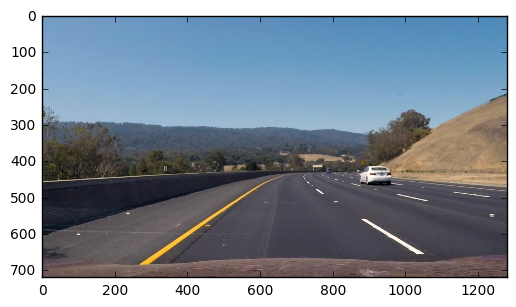

In [154]:
test_image=mpimg.imread("test_images/test3.jpg")
plt.imshow(test_image)

In [155]:
image_copy=np.copy(test_image)
hot_windows,all_windows=get_rectangle_cars(image_copy)

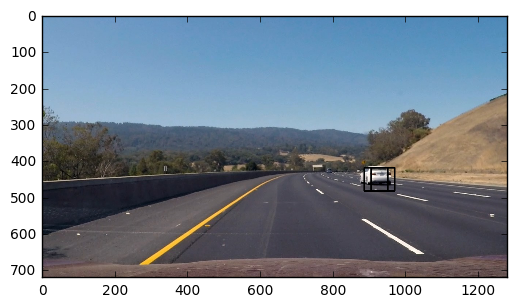

In [156]:
draw_image = np.copy(test_image)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4) 
plt.imshow(window_img)

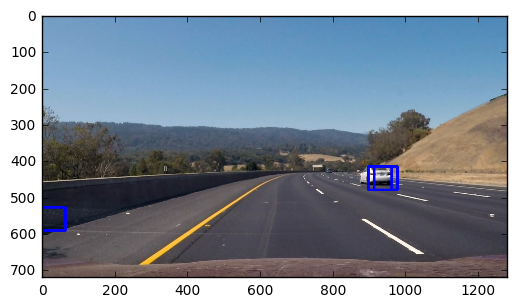

In [160]:
out_img,boxlist= find_cars(test_image, ystart, ystop, 1, svc, X_scaler, \
                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)

In [161]:
boxlist

[((0, 528), (64, 592)), ((896, 416), (960, 480)), ((912, 416), (976, 480))]

In [162]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

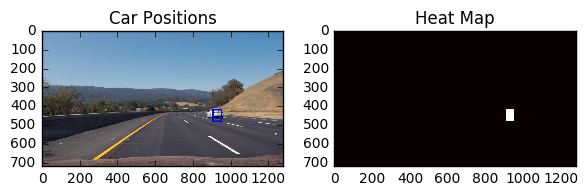

In [163]:
from scipy.ndimage.measurements import label
image = mpimg.imread('test_images/test3.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)
box_list=hot_windows
heat = add_heat(heat,box_list)
#heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

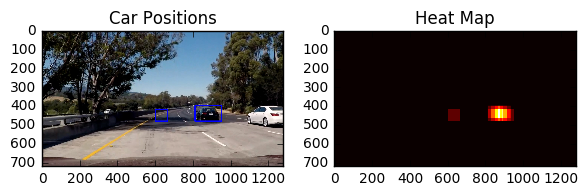

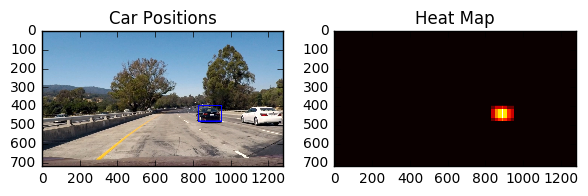

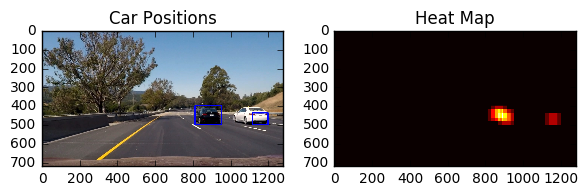

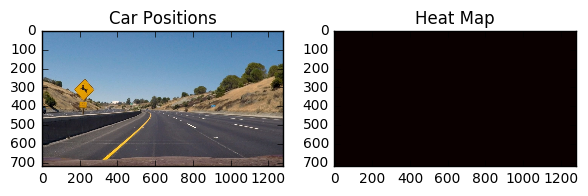

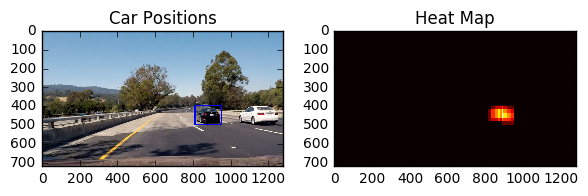

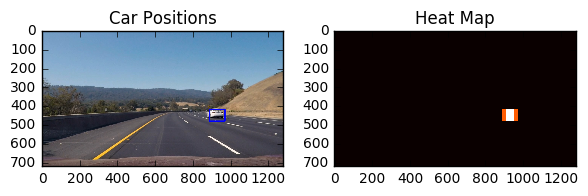

In [174]:
images=glob.glob("test_images/*.jpg")
for i in range(len(images)):
    image = mpimg.imread(images[i])
    hot_windows,all_windows=get_rectangle_cars(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    box_list=hot_windows
    heat = add_heat(heat,box_list)
    #heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

In [175]:
def process_image(image):
    hot_windows,all_windows=get_rectangle_cars(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    box_list=hot_windows
    heat = add_heat(heat,box_list)
    #heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

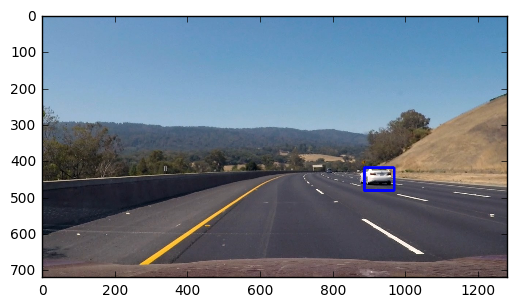

In [176]:
image=mpimg.imread('test_images/test3.jpg')
plt.imshow(process_image(image))

In [38]:
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0%)2531328/28549024 bytes (8.9%)5177344/28549024 bytes (18.1%)7700480/28549024 bytes (27.0%)10223616/28549024 bytes (35.8%)12763136/28549024 bytes (44.7%)15269888/28549024 bytes (53.5%)17743872/28549024 bytes (62.2%)20316160/28549024 bytes (71.2%)22806528/28549024 bytes (79.9%)25255936/28549024 bytes (88.5%)28123136/28549024 bytes (98.5%)28549024/28549024 bytes (100.0%)
  Done
File saved as /home/carnd/.imageio/

In [177]:
from moviepy.editor import VideoFileClip
video_output = 'result_test.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result_test.mp4
[MoviePy] Writing video result_test.mp4


 97%|█████████▋| 38/39 [01:09<00:01,  1.84s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_test.mp4 



In [178]:
from moviepy.editor import VideoFileClip
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [38:13<00:01,  1.81s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

